In [1]:
from keras.optimizers import adam_v2
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import  conv2d,MaxPooling2D







#### PARAMETERS

In [2]:
path = "C:\\Users\\VishnuPriya\\Desktop\\datascience\\myData"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2

#### IMPORTING OF THE IMAGE

In [3]:
import numpy as np
import os
import cv2
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


#### SPLIT DATA

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)


#### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET

In [5]:
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0] == y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:] == (imageDimesions)), " The dimesions of the Training images are wrong "
assert (X_validation.shape[1:] == (imageDimesions)), " The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:] == (imageDimesions)), " The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


#### READ CSV FILE

In [6]:
import pandas as pd
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


#### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES

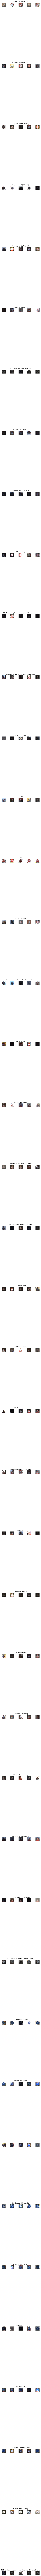

In [7]:
import matplotlib.pyplot as plt
import random
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

#### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY

[126, 1258, 1275, 801, 1147, 1053, 237, 829, 825, 822, 1173, 739, 1232, 1222, 453, 345, 224, 658, 670, 122, 169, 164, 222, 306, 154, 839, 363, 120, 306, 151, 244, 460, 136, 371, 225, 684, 209, 115, 1198, 172, 189, 131, 132]


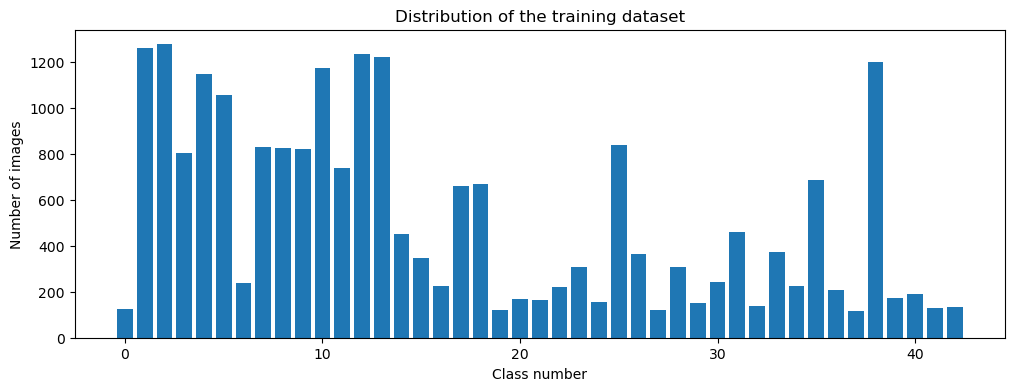

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


#### PREPROCESSING THE IMAGES

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):# CONVERT TO GRAYSCALE
    img = grayscale(img) # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = equalize(img) # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    img = img / 255
    return img


X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY


#### ADD A DEPTH OF 1

In [10]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

#### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC

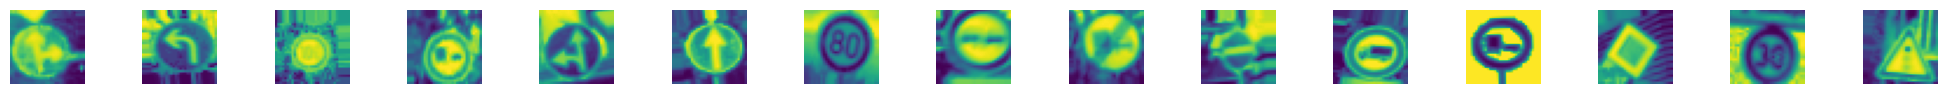

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
dataGen = ImageDataGenerator(width_shift_range=0.1, ## 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2, # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10) # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20) # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

#### CONVOLUTION NEURAL NETWORK MODEL

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import Adam
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
     # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2) # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500 # NO. OF NODES IN HIDDEN LAYERS
    imageDimesions=(32,32)
    noOfClasses=43
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu'))) # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense( noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### TRAIN

In [13]:
from keras.layers import Conv2D
from keras.layers import Dropout,Flatten

from keras.layers import Dense
# model = myModel()
# print(model.summary())


#### TRAIN

In [14]:
model = myModel()
print(model.summary())
history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=5),
                              steps_per_epoch=steps_per_epoch_val, epochs=10,
                              validation_data=(X_validation, y_validation), shuffle=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

C:\Users\VishnuPriya\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\VishnuPriya\AppData\Local\Temp\ipykernel_5640\2308825470.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=5),


None
Epoch 1/10
2000/2000 [==============================] - 67s 33ms/step - loss: 2.8472 - accuracy: 0.2108 - val_loss: 1.4950 - val_accuracy: 0.5260
Epoch 2/10
2000/2000 [==============================] - 53s 26ms/step - loss: 1.6492 - accuracy: 0.4926 - val_loss: 0.7832 - val_accuracy: 0.7735
Epoch 3/10
2000/2000 [==============================] - 47s 23ms/step - loss: 1.2207 - accuracy: 0.6219 - val_loss: 0.5248 - val_accuracy: 0.8227
Epoch 4/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.9712 - accuracy: 0.6977 - val_loss: 0.2861 - val_accuracy: 0.9142
Epoch 5/10
2000/2000 [==============================] - 47s 24ms/step - loss: 0.8326 - accuracy: 0.7418 - val_loss: 0.2719 - val_accuracy: 0.9077
Epoch 6/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.7275 - accuracy: 0.7740 - val_loss: 0.2289 - val_accuracy: 0.9300
Epoch 7/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.7134 - accuracy: 0.7781 - val_loss: 0.2

#### PLOT

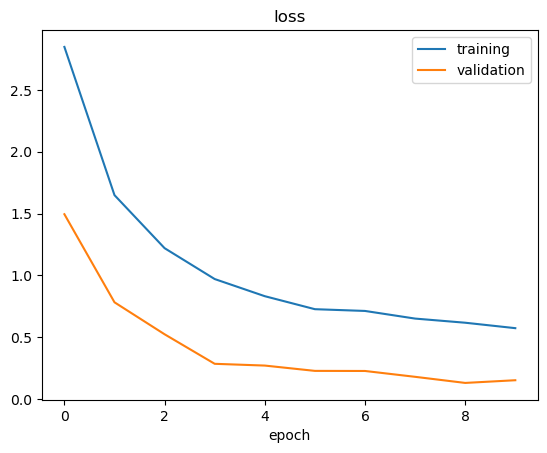

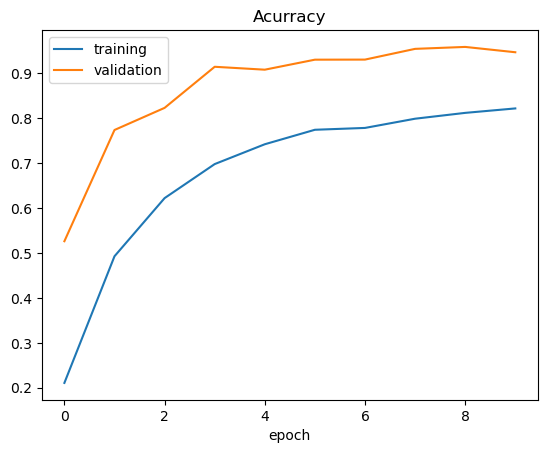

Test Score: 0.1536988765001297
Test Accuracy: 0.9505746960639954


In [15]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.title('Acurracy')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])


#### # STORE THE MODEL AS A H5 FILE

In [16]:
import keras
model.save('modeltraing_saved2.h5')
loaded_model=keras.models.load_model('modeltraing_saved2.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    